# Basic String Matching

The Consumer Price Index Program at the Bureau of Labor Statistics uses a survey called the Telephone Point of Purchase Survey (TPOPS) to collect data on where people shop. <a href="https://www.bls.gov/opub/hom/pdf/homch17.pdf">The BLS Handbook of Methods</a> discusses this survey, starting on page 13.

One could imagine the various ways store names and locations show up in survey data. Incorrect spelling ("Wallmart" vs "Wal-Mart") and regional understandings ("King St" vs "Route 7") are common reasons for the variations. The added task of matching incoming reports to a database table of previous reports (record linking) means a considerable amount of effort is used to clean or standardize survey data.

Testing ways to improve this process is important and designing a test is the focus of this post. In this post we will use string distance to match mock survey reports to a universe of stores in an attempt to standardize the names reported.

### Import Libraries

Let's import the needed libraries before we continue.

<ol>
<li>Pandas</li>
<li>Numpy</li>
<li>JellyFish</li>
<li>Itertools</li>
<li>Matplotlib</li>
</ol>

In [1]:
import pandas as pd
import numpy as np
import jellyfish as jf
import itertools as it
import matplotlib.pyplot as plt

### Creating Tables

Two tables are required for this test:
<ol>
    <li>An answer key or "gold standard"</li>
    <li>A universe of standardized store names.</li>
</ol>

The answer key will allow us to determine whether a suggested match is the correct store name or not. The answer key is the most time consuming and underappreciated part of preparing these investigations. 

The universe is a list of all correct store names. When testing it is helpful to make sure all reported store names have a possible match in the universe list. Otherwise, there is the possibility of a store name guaranteed to not have a match, regardless of the algorithm used. Since the goal is to test an algorithm, that would be an unhelpful result.

#### Table 1: Answer Key

An answer key has two things--a report and an answer. If a report is located all in one column, then there will be only two columns. In our case, the report is simply a store name. Depending on what needs to be matched, more columns could be added, such as a city, state, street name, or some sort of categorical identifier. In this test, one column will be populated with incoming survey data and another populated with the standardized name (the answer).

For example, let's say we received four reports, as shown in the table below. The reported store names are on the left and the "correct" store names are on the right. Notice we can have duplicates of the correct store name; duplicate standardized store names are fine and expected.

<table style="width:25%">
  <caption>Format for Answer Key</caption>
    <tr>
      <th>Reported Store Name (Survey)</th>
      <th>Standardized Store Name (Answer)</th> 
    </tr>
    <tr>
      <td>Bst Bye</td>
      <td>Best Buy</td>
    </tr>
    <tr>
      <td>Bestby</td>
      <td>Best Buy</td> 
    </tr> 
    <tr>
      <td>Wal mert</td>
      <td>Wal-Mart</td> 
    </tr>
    <tr>
      <td>While food</td>
      <td>Whole Foods Market</td> 
    </tr>   
</table>
<br>
Humorously, the steps to create mock data (and answer key) are the reverse for creating a key from actual survey data. First, I searched for grocery stores using <a href="https://developers.google.com/places/">Google's API</a>, culminating in 158 stores from 12 cities in 9 states. Second, since Google returned to me perfectly formatted store names, I had to deliberately make typos in the store names to simulate survey data.

The answer key is available on my <a href="https://github.com/gfbarbieri/Data_Analysis_Python/blob/master/Basic_String_Matching_Answer_Key.xls">Github page</a>, with an import statement below.

In [2]:
answer_key = pd.read_excel(io="Basic_String_Matching_Answer_Key.xls",
                           sheet="Reported Stores")
answer_key.head()

,Reported,Answer
0,A Mattier ofh Hellth,A Matter of Health
1,A&G Freshq Markeht,A&G Fresh Market
2,A-Groncery Warehgouse,A-Grocery Warehouse
3,ndronicos Maket,Andronico's Market
4,Atla Market,Atlas Market


#### Table 2: Universe

The second table is the universe of stores. This is the list of all possible stores in the universe to match a survey report to. To create that from the first table, take the unique reports of the standardized column.

The format for the universe table is below.

<table style="width:15%">
    <caption>Format for Universe</caption>
    <tr>
        <th>Standardized Store Name</th> 
    </tr>
    <tr>
        <td>Wal-Mart</td>
    </tr>
    <tr>
        <td>Best Buy</td>
    </tr>
    <tr>
        <td>Whole Foods Market</td>
    </tr>
</table>

In [3]:
df = answer_key['Answer'].drop_duplicates(inplace=False)
df.rename(index='Standardized Name', inplace=True)
df.head()

0     A Matter of Health
1       A&G Fresh Market
2    A-Grocery Warehouse
3     Andronico's Market
4           Atlas Market
Name: Standardized Name, dtype: object

### Functions
This is where you would define the functions which would calculate the string distances. There are several available through the <b>JellyFish</b> library, and below I listed five of the most common string distance measures used. For this post, I only wrote one function using the Levenshtein distance.
<ol>
<li>Soundex</li>
<li>Levenshtein Distance</li>
<li>Damerau-Levenshtein Distance</li>
<li>Jaro Distance</li>
<li>Jaro-Winkler Distance</li>
</ol>

In [4]:
def calc_leven(row):
    reported_store = row['Reported']
    standardized_store = row['Standardized Name']
    return jf.levenshtein_distance(reported_store, standardized_store)

### Suggest Matching Store Name (Minimum String Distance)

Lets walk through the steps for determining a best match using string distance.

<ol>
<li>
For each store reported, we will use the <b>product()</b> function from the <b>Itertools</b> library to create a Cartesian product between the reported store and every store name in the universe. The resulting list, called <b>comparisons</b>, will have one column for the reported store name and one column for every store name in the universe. There will be as many rows as there are store names in the universe table. Use the <b>comparision</b> list to populate a dataframe called <b>compare_store_names</b>.
</li>
<table style="width:25%">
    <caption>Example for "Bst Bye"</caption>
    <tr>
      <th>Reported Store Name</th>
      <th>Standardized Store Name</th>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Wal-Mart</td>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Whole Foods</td>
    </tr>
</table>
<br>
<li>
Add back the correct store name associated with the reported store name to the dataframe <b>compare_store_names</b>. We will use it to compare the correct store name with the store name selected at the end of the algorithm.
</li>
<table style="width:50%">
    <caption>Example for "Bst Bye"</caption>
    <tr>
      <th>Reported Store Name</th>
      <th>Standardized Store Name</th>
      <th>Answer/Correct Store Name</th>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Wal-Mart</td>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Best Buy</td>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Whole Foods</td>
    </tr>
</table>
<br>
<li>
Calculate the string distance between the reported store name and the standardized store name from the universe dataset.
</li>
<table style="width:75%">
    <caption>Example for "Bst Bye"</caption>
    <tr>
      <th>Reported Store Name</th>
      <th>Standardized Store Name</th>
      <th>Answer/Correct Store Name</th>
      <th>Distance Measure</th>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Wal-Mart</td>
        <td>8</td>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Best Buy</td>
        <td>3</td>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Whole Foods</td>
        <td>12</td>
    </tr>
</table>
<br>
<li>
This next step is to design a tie breaker rule if minimum string distances that are equal. In this test plan we select with equal probability using the <b>sample()</b> function in the <b>Pandas</b> library. Equal probabilities can be used setting the parameter <b>weights</b> equal to "None". Store the selected store name in a dataframe called <b>suggestion</b>.
</li>
<table style="width:75%">
    <caption>Final dataset with suggested store name by algorithm</caption>
    <tr>
      <th>Reported Store Name</th>
      <th>Standardized Store Name</th>
      <th>Answer/Correct Store Name</th>
      <th>Distance Measure</th>
    </tr>
    <tr>
        <td>Bst Bye</td>
        <td>Best Buy</td>
        <td>Best Buy</td>
        <td>3</td>
    </tr>
</table>
<br>
<li>
Finally, append the store name suggested by the algorithm in <b>suggestion</b> to a dataframe called <b>suggested_store_names</b>.
</li>
</ol>

In [5]:
suggested_store_names = pd.DataFrame()

for index, store in answer_key.iterrows():
    #1.
    comparisons = list(it.product([store[0]], df))
    compare_store_names = pd.DataFrame(comparisons, columns=['Reported', 'Standardized Name'])
    
    #2.
    compare_store_names['Answer'] = store[1]
    
    #3.
    compare_store_names['Leven_Dist'] = compare_store_names.apply(calc_leven, axis=1)

    #4.
    minimum_string_distance = min(compare_store_names['Leven_Dist'])
    
    suggestion = compare_store_names[compare_store_names['Leven_Dist'] == minimum_string_distance]
    suggestion = suggestion.sample(n=1, replace=False, weights=None, random_state=101)
    
    #5.
    suggested_store_names = suggested_store_names.append(suggestion)

### Determining a Match

If the suggested store name equals the correct store name associated with the reported store name, then Match = 1, otherwise Match = 0. The assignment of the variable Match is done using the <b>where()</b> function from the <b>Numpy</b> library.

In [6]:
suggested_store_names['Leven_Dist_Match'] = np.where(suggested_store_names['Answer'] == suggested_store_names['Standardized Name'], 1, 0)
suggested_store_names.head()

,Reported,Standardized Name,Answer,Leven_Dist,Leven_Dist_Match
0,A Mattier ofh Hellth,A Matter of Health,A Matter of Health,3,1
1,A&G Freshq Markeht,A&G Fresh Market,A&G Fresh Market,2,1
2,A-Groncery Warehgouse,A-Grocery Warehouse,A-Grocery Warehouse,2,1
3,ndronicos Maket,Andronico's Market,Andronico's Market,3,1
4,Atla Market,Atlas Market,Atlas Market,1,1


#### Plotting Match Rates

In this test, we only used one string distance measure, however, a real test would involve several. In that situation, we would want to plot the match rate of each string distance measure. The graph below, while naive with only one measure, shows that selecting a store based on the minimum Levenshtein distance was correct 100% of the time. I guess the typos I made were not realistic enough!

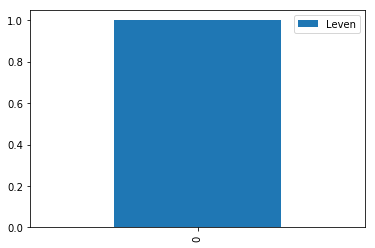

In [7]:
Leven_Dist_Match_Rate = suggested_store_names['Leven_Dist_Match'].value_counts()[1] / len(suggested_store_names)
Match_Rates = pd.DataFrame(np.column_stack([Leven_Dist_Match_Rate]),columns=['Leven'])

Match_Rates.plot(kind='bar')
plt.show()

### Export Matches to Excel

We may also want to export the matches to Excel, which is another place one would calculate and plot match rates (change the file path).

In [8]:
suggested_store_names.to_excel(excel_writer="Basic_String_Matching_Results.xls", 
                               sheet_name="Suggested Store Names", 
                               index=False)